In [1]:
from PIL import Image
from functools import reduce, partial
from multiprocessing import Pool
from matplotlib import pyplot as mp
from mpmath import mp
from mpmath import pi as Pi
from mpmath import sin as Sin
from mpmath import asin as Asin
from mpmath import sqrt as Sqrt

import matplotlib.image as mpimg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Laurent Boue, in his paper "Real numbers, data science and chaos: How to fit any dataset with a single parameter" shows how any dataset of any modality (time-series, images, sound...)  can be approximated by a well-behaved  (continuous,  differentiable...) scalar  function  with  a  single  real-valued  parameter. The paper can be found here.

All the code and concepts in this Jupyter notebook are based on the work of Laurent Boue.

In [2]:
print('https://arxiv.org/pdf/1904.12320.pdf')

https://arxiv.org/pdf/1904.12320.pdf


The equation is the following:


$$ f_{\alpha \left ( X \right )}=sin^{^{2}}(2^{x\tau }arcsin\sqrt{\alpha })\$$

In [3]:
color = './images/color.png'
b_and_w = './images/blackandwhite.png'
image_color = mpimg.imread(color)
image_bw = mpimg.imread(b_and_w)
image_pil = Image.open(b_and_w)

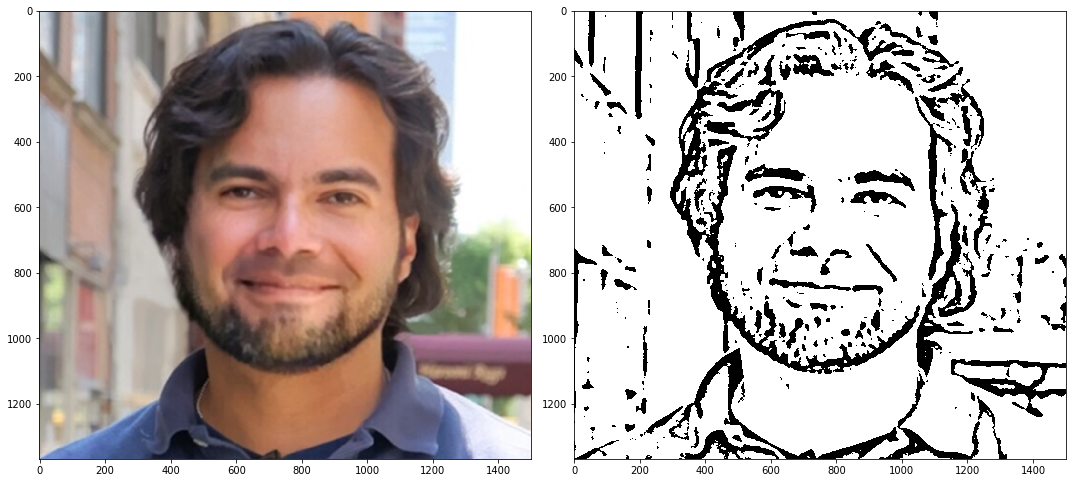

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
axes[0].imshow(image_color)
axes[1].imshow(image_bw)

fig.tight_layout()

In [5]:
image_color

array([[[0.80784315, 0.84705883, 0.85490197, 0.87058824],
        [0.80784315, 0.84705883, 0.85490197, 0.92941177],
        [0.8117647 , 0.8509804 , 0.85882354, 1.        ],
        ...,
        [1.        , 1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        , 0.92941177],
        [1.        , 1.        , 1.        , 0.87058824]],

       [[0.80784315, 0.84705883, 0.85490197, 0.92941177],
        [0.80784315, 0.84705883, 0.85490197, 0.99215686],
        [0.8117647 , 0.8509804 , 0.85882354, 1.        ],
        ...,
        [1.        , 1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        , 0.99215686],
        [1.        , 1.        , 1.        , 0.92941177]],

       [[0.8039216 , 0.84313726, 0.8509804 , 0.93333334],
        [0.8039216 , 0.84313726, 0.85490197, 0.99607843],
        [0.80784315, 0.8509804 , 0.85882354, 1.        ],
        ...,
        [1.        , 1.        , 1.        , 1.        ],
        [1.        , 1.      

In [6]:
image_bw

array([[[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       ...,

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       [[1., 1., 1., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        ...,
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [0., 0., 0., 1.],
        ...,
        [1., 1., 1., 1.],
        [1., 1.

In [7]:
image = image_pil.convert('L').point(lambda x : 0 if x > 100 else 255).convert('1')

In [8]:
img = np.rot90(np.asarray(image), k=3)

In [9]:
width, height = img.shape
possiblePositions = list(zip(*np.where(img)))

In [10]:
sampleAndScale = lambda gr: gr['y'].sample().values[0] / height

data = pd.DataFrame(possiblePositions, columns=['x', 'y']).groupby('x').apply(sampleAndScale)
data = data.reindex(np.arange(0, width), fill_value=-10)

data = data[data > 0]
numbPoints = len(data)
data.index = range(numbPoints)

In [11]:
phiInv = lambda z: np.arcsin(np.sqrt(z)) / (2.0 * np.pi)
decimalToBinary_phiInv = lambda z: decimalToBinary(phiInv(z))
phi = lambda theta: Sin(theta * Pi * 2.0) ** 2
dyadicMap = lambda x : (2 * x) % 1
tau = 12

In [12]:
def decimalToBinary(decimalInitial, targetBinaryPrecision = tau):
    return reduce(lambda acc, _: [dyadicMap(acc[0]), acc[1] + ('0' if acc[0] < 0.5 else '1')], 
                  range(targetBinaryPrecision), 
                  [decimalInitial, ''])[1]

In [13]:
def binaryToDecimal(binaryInitial):
    return reduce(lambda acc, val: acc + int(val[1]) / mp.power(2, (val[0] + 1)), 
                  enumerate(binaryInitial), 
                  mp.mpf(0.0))

In [14]:
def binaryReducer(val):
    return int(val[1]) / mp.power(2, (val[0] + 1))

In [15]:
def binaryToDecFaster(binaryInitial):

    with Pool(8) as p:
        tt = p.map(binaryReducer, enumerate(binaryInitial))

    res = mp.mpf(0)
    for _ in tt:
        res += _
    
    return res

In [16]:
def dyadicDecoder(decimalInitial, k):
    return (2 ** (k * tau) * decimalInitial) % 1

In [17]:
def logisticDecoder(decimalInitial, k):
    return float(Sin(2 ** (k * tau) * Asin(Sqrt(decimalInitial))) ** 2)

In [18]:
def findInitialCondition(trainData):
    conjugateInitial_binary = ''.join(map(decimalToBinary_phiInv, trainData))

    necessaryPrecision = len(conjugateInitial_binary)
    assert tau * len(trainData) == necessaryPrecision
    
    # data is passed through sequentially so no need to worry
    # plus, all samples have the same size anyway
    # to be safe, these global settings should be handled more carefully with context managers
    
    mp.prec = necessaryPrecision 
    print('significance = %d bits ; %d digits (base-10) ; ratio = %.3f\n' % (mp.prec, mp.dps, mp.prec / mp.dps))

    # conjugateInitial = binaryToDecimal(conjugateInitial_binary)
    conjugateInitial = binaryToDecFaster(conjugateInitial_binary)
    decimalInitial = phi(conjugateInitial)

    return decimalInitial

In [19]:
def generateData(decimalInitial, howManyPoints):
    p_logisticDecoder = partial(logisticDecoder, decimalInitial)
    with Pool(8) as p:
        decodedValues = p.map(p_logisticDecoder, range(howManyPoints))
    return decodedValues

In [20]:
decimalInitial = findInitialCondition(data)

significance = 17988 bits ; 5414 digits (base-10) ; ratio = 3.322



In [21]:
decodedValues = generateData(decimalInitial, len(data))

In [22]:
decimalInitial

mpf('0.420640836421844838682752124007091999048152246361724978711681851359844118039082814242783819058257277690397919218043994639766516123924000674497327909406500105349682313274888986243244314783021063135184616008400150371928561669391875818290334191973504722996482487945711169151100299605604502304694167889292497575448833065051298428032181361143290666784278789537571311590952672557444074470603677845196502300595138889411050075620652109671311461375001445494344100541707564393025390937712673904961861281006738566445086347085910464798658572265837957889437622527130397898174040933016733251959738546326748155400495030963825992814997731120902629771592764596609010742603180301235464898746847714124601012469701580069858576559195377879017799528749745937244415749809724867230114182297687132272423844874919331143572939915510709075823134851332518736594088119408307717546784797879947427718756948620711754876073924745590621833871994911030259498388305276239306618703244756036120478309156631026653737358204407152284130

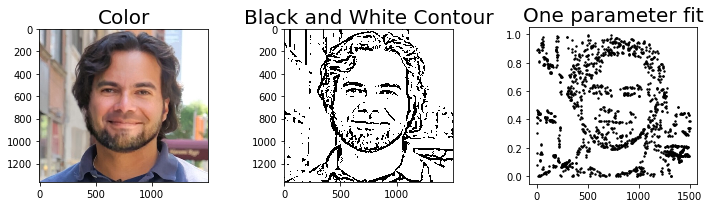

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))
axes[0].imshow(image_color)
axes[0].set_title('Color', fontsize=20)
axes[1].imshow(image_bw)
axes[1].set_title('Black and White Contour', fontsize=20)
axes[2].scatter(range(len(decodedValues)), decodedValues, color='black', s=2)
axes[2].set_title('One parameter fit', fontsize=20)
fig.tight_layout()